In [22]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer, SimpleImputer
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, ParameterGrid
from sklearn.decomposition import PCA


#import knn classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestClassifier
import catboost as cb
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import mean_absolute_error,  mean_squared_error, r2_score, accuracy_score

# import tensorflow as tf
# from keras.models import Sequential
# from keras.layers import Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras import regularizers
# from keras import initializers
# from keras.layers import BatchNormalization
# from tensorflow.keras.constraints import MaxNorm
# from kerastuner.tuners import Hyperband

# from tensorflow.keras.optimizers import Adam

# import shap
# from lime import lime_tabular


In [23]:
train = pd.read_csv('data/train.csv')
train2 = pd.read_csv('data/training_extra.csv')
test = pd.read_csv('data/test.csv')


In [24]:
train = pd.concat([train, train2], axis=0)
train.reset_index(inplace=True, drop=True)
train.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


### Encode Categories

In [25]:
binary_cols = ['Laptop Compartment', 'Waterproof']

mapping = {'Yes': 1, 'No': 0}

train[binary_cols] = train[binary_cols].map(mapping.get)
test[binary_cols] = test[binary_cols].map(mapping.get)

In [26]:
cat_cols = ['Brand', 'Material', 'Size', 'Style', 'Color',  'Laptop Compartment', 'Waterproof']

# group by brand, material, size, style, color, laptop compartment, waterproof and average price
map_dicts = {}

for col in cat_cols:
    map_dict = (train.groupby([col])['Price'].mean().reset_index().sort_values(by='Price', ascending=True))
    map_dict = dict(zip(map_dict[col], range(0,map_dict.shape[0])))

    new_col = col + '_enc'

    train[new_col] = train[col].map(map_dict)
    test[new_col] = test[col].map(map_dict)
    
    reverse_map_dict = dict(zip(map_dict.values(), map_dict.keys()))
    map_dicts[new_col] = reverse_map_dict

### Feature Imputation

In [27]:
print(train.isna().sum().sum())
imputer = IterativeImputer(max_iter=10, random_state=42)

num_cols = [col for col in train.columns if train[col].dtype in ['float64', 'int64']]
num_cols.remove('Price')

train[num_cols] = imputer.fit_transform(train[num_cols])
test[num_cols] = imputer.transform(test[num_cols])
print(train.isna().sum().sum())

1514126
563302


In [28]:
# reverse fill in the categorical columns after imputation
print(train.isna().sum().sum())

for col in cat_cols:
    new_col = col + '_enc'
    # round the values to nearest integer
    train[new_col]  = train[new_col].apply(lambda x: round(x))
    test[new_col]  = test[new_col].apply(lambda x: round(x))

    train[col] = train[new_col].map(map_dicts[new_col])
    test[col] = test[new_col].map(map_dicts[new_col])

print(train.isna().sum().sum())

563302
0


In [29]:
# checkpoint 

train.to_csv('data/train_imputed_.csv', index=False)
test.to_csv('data/test_imputed_.csv', index=False)

### Feature Engineering 

In [30]:
train = pd.read_csv('data/train_imputed_.csv')
test = pd.read_csv('data/test_imputed_.csv')

In [31]:
def engineer_features(df):

    df['weight_capacity_rounded'] = df['Weight Capacity (kg)'].apply(lambda x: round(x))
    
    binner = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
    binned_values = binner.fit_transform(df[['weight_capacity_rounded']]).astype(int).flatten()

    # Create bin category column
    bin_col_name = f"weight_capacity_bins"
    df[bin_col_name] = binned_values

    df['brand_material'] = df['Brand'].astype(str) + '_' + df['Material'].astype(str)
    df['brand_material'] = df['brand_material'].astype('category').cat.codes

    df['brand_size'] = df['Brand'].astype(str) + '_' + df['Size'].astype(str)
    df['brand_size'] = df['brand_size'].astype('category').cat.codes

    df['style_size'] = df['Style'].astype(str) + '_' + df['Size'].astype(str)
    df['style_size'] = df['style_size'].astype('category').cat.codes

    df['style_material'] = df['Style'].astype(str) + '_' + df['Material'].astype(str)
    df['style_material'] = df['style_material'].astype('category').cat.codes

    df['color_material'] = df['Color'].astype(str) + '_' + df['Material'].astype(str)
    df['color_material'] = df['color_material'].astype('category').cat.codes

    df['weight_capacity_ratio'] = df['Weight Capacity (kg)'] / df['Weight Capacity (kg)'].max()

    df['weight_to_compartments'] = df['Weight Capacity (kg)'] / (df['Compartments'] + 1)


    df['compartments_bins'] = pd.cut(df['Compartments'], bins=[0, 2, 5, 10, np.inf], labels=['Few', 'Moderate', 'Many', 'Very Many'])
    df['compartments_bins'] = df['compartments_bins'].astype('category').cat.codes

    #dark vs light color
    mapping = {'Blue': '1', 'Gray': '1', 'Black': '1', 'Green': '0', 'Pink': '0', 'Red': '0'}
    df['color_cat'] = df['Color'].map(mapping.get)
    df['color_cat'] = df['color_cat'].astype(int)

    columns = [col.lower() for col in df.columns]
    df.columns = columns

    df = df.rename(columns={'weight capacity (kg)':'weight_capacity'})

    df['brand_avg_weight_capacity'] = df.groupby('brand')['weight_capacity'].transform('mean')
    df['style_avg_weight_capacity'] = df.groupby('style')['weight_capacity'].transform('mean')
    df['color_avg_weight_capacity'] = df.groupby('color')['weight_capacity'].transform('mean')
    df['compartments_avg_weight_capacity'] = df.groupby('compartments')['weight_capacity'].transform('mean')
    df['size_avg_weight_capacity'] = df.groupby('size')['weight_capacity'].transform('mean')

    df = df.drop(columns=['brand', 'material', 'size', 'style', 'color'])

    return df 

train = engineer_features(train.copy())
test = engineer_features(test.copy())



### Target Encoding

In [32]:
feature_cols = [col for col in train.columns if col not in ['id', 'price']]
new_feature_cols = [feature + '_te' for feature in feature_cols]

In [33]:
encoder = TargetEncoder(cols=feature_cols, smoothing=10)

train[new_feature_cols] = None
train[new_feature_cols] = encoder.fit_transform(train[feature_cols], train['price'])

test[new_feature_cols] = None
test[new_feature_cols] = encoder.transform(test[feature_cols])

### Scaling

In [34]:
feature_cols = [col for col in train.columns if col not in ['id', 'price']]


In [35]:
scaler = StandardScaler()

train[feature_cols] = scaler.fit_transform(train[feature_cols])
test[feature_cols] = scaler.transform(test[feature_cols])

### PCA

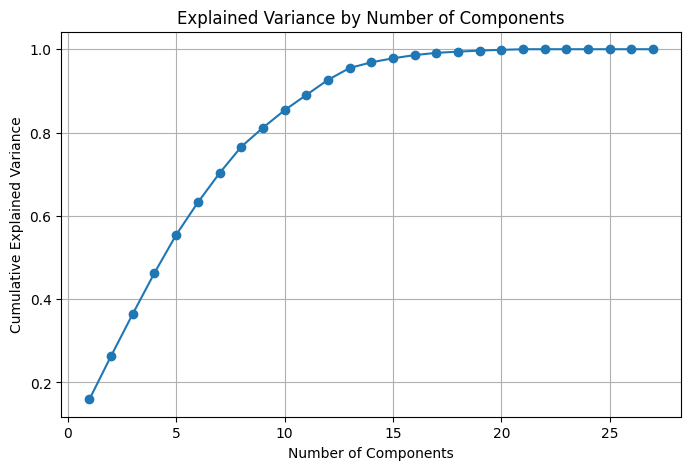

In [13]:
# Apply PCA
pca = PCA().fit(train[feature_cols])

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.grid(True)
plt.show()


In [14]:
pca = PCA(n_components=12)  # Reduce to 19 components
X_pca = pca.fit_transform(train[feature_cols])
X_pca = pd.DataFrame(X_pca, columns=[f'PC_{i}' for i in range(1, X_pca.shape[1] + 1)])

test_pca = pca.transform(test[feature_cols])
test_pca = pd.DataFrame(test_pca, columns=[f'PC_{i}' for i in range(1, test_pca.shape[1] + 1)])

train = pd.concat([train, X_pca], axis=1)
test = pd.concat([test, test_pca], axis=1)

### CB Model

In [36]:

X = None 
y = None 

cb_params = {
    'iterations': [500],
    'learning_rate': [0.1],
    'depth': [4]
}

cb_model = cb.CatBoostRegressor(verbose=0, random_state=42, loss_function='RMSE')


# Grid search setups
def run_grid_search(model, params, name, scoring='neg_root_mean_squared_error', X=X, y=y):
    grid = GridSearchCV(model, params, cv=3, scoring=scoring, n_jobs=-1)
    grid.fit(X, y)
    print(f"Best parameters for {name}: {grid.best_params_}")
    print(f"Best score for {name}: {-grid.best_score_}")
    return grid.best_estimator_


In [37]:
X = train[feature_cols]#X_pca#
y = train['price']
best_cb = run_grid_search(cb_model, cb_params, "CatBoost", X=X, y=y)


Best parameters for CatBoost: {'depth': 4, 'iterations': 500, 'learning_rate': 0.1}
Best score for CatBoost: 25.53144891150119


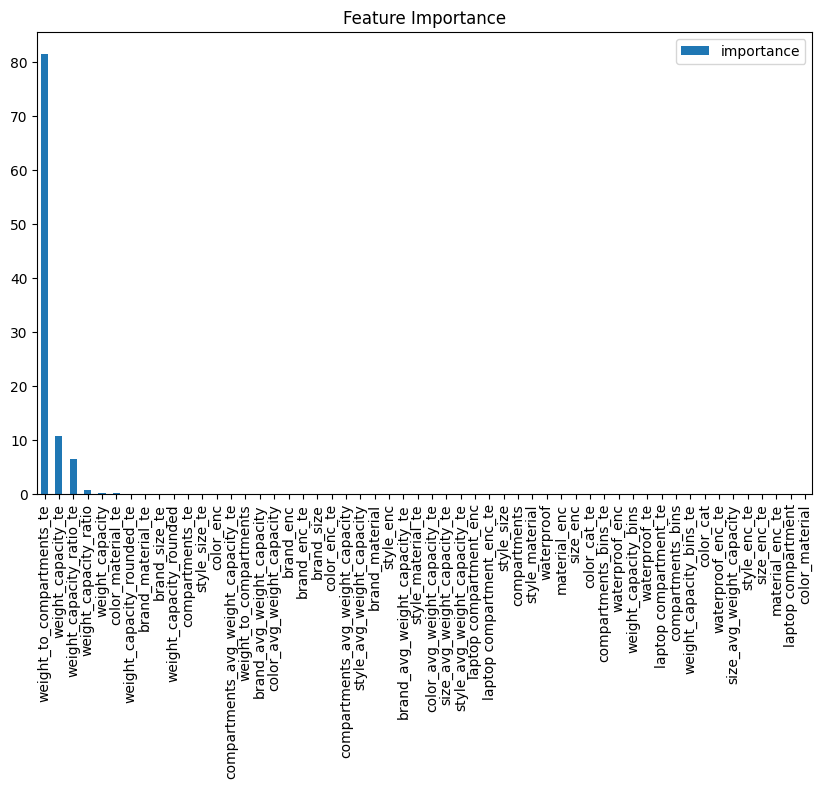

In [38]:
# plot feature importance of cat boost regressor

feature_importances = pd.DataFrame(best_cb.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)

feature_importances.plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importance')
plt.show()

In [48]:
test['price_te'] = best_cb.predict(test[X.columns])

In [49]:
feature_cols = [col for col in train.columns if col not in ['id', 'price'] and '_te' not in col]

X = train[feature_cols]#X_pca#
y = train['price']
best_cb = run_grid_search(cb_model, cb_params, "CatBoost", X=X, y=y)


Best parameters for CatBoost: {'depth': 4, 'iterations': 500, 'learning_rate': 0.1}
Best score for CatBoost: 38.89916220991614


In [50]:
test['price_no_te'] = best_cb.predict(test[X.columns])

In [52]:
X = X_pca
y = train['price']

best_cb = run_grid_search(cb_model, cb_params, "CatBoost", X=X, y=y)


Best parameters for CatBoost: {'depth': 4, 'iterations': 500, 'learning_rate': 0.1}
Best score for CatBoost: 38.91184745590298


In [51]:
test['price_pca'] = best_cb.predict(test[X.columns])

In [53]:
test['price'] = test[['price_no_te', 'price_te', 'price_pca']].mean(axis=1)

In [54]:
def create_submission_file(sub_df):
    submission = sub_df[['id', 'price']]
    submission = submission.rename(columns={'price': 'Price'})
    print(submission.isna().sum().sum())
    display(submission.head())
    file_name = datetime.now().strftime('submissions/submission_%Y%m%d_%H%M.csv')
    submission.to_csv(file_name, index = False)

In [55]:
create_submission_file(test)

0


,id,Price
0,300000.0,77.483869
1,300001.0,95.126020
2,300002.0,88.238544
3,300003.0,73.252448
4,300004.0,79.048614


In [47]:
lgb_params = {
    'n_estimators': [500],
    'learning_rate': [0.1],
    'num_leaves': [40]
}

lgb_model = lgb.LGBMRegressor(random_state=42, objective='regression', metric='rmse')

print("Running GridSearch for LightGBM...")
best_lgb = run_grid_search(lgb_model, lgb_params, "LightGBM", X=X, y=y)

Running GridSearch for LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1940
[LightGBM] [Info] Number of data points in the train set: 2662879, number of used features: 54
[LightGBM] [Info] Start training from score 81.383128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1940
[LightGBM] [Info] Number of data points in the train set

In [89]:
X = train[final_features]
y = train['price']

best_cb = run_grid_search(cb_model, cb_params, "CatBoost", X=X, y=y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 2662878, number of used features: 8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 2662879, number of used features: 8
[LightGBM] [Info] Number of data po

### Neural Network

In [ ]:
train_features = train[final_features]
test_features = test[final_features]

train_labels = train['price']

In [ ]:
def build_model(hp):

  model = Sequential()

  # 0.3 to 0.4
  hp_dropout_1 = hp.Float('rate', min_value=0.3, max_value=0.4, step=0.1)
  model.add(BatchNormalization())
  model.add(Dropout(hp_dropout_1, input_shape=(train_features.shape[1],)))

  # Tune the number of dense layers
  for i in range(hp.Int('num_layers', 1, 3)):


    '''
    iterations of tuning nodes in each layer
    '''
    # hp_units = hp.Int('units_'+str(i), min_value=440, max_value=490, step=10)
    hp_units = hp.Int('units_'+str(i), min_value=440, max_value=490, step=10)

    # get max norm penalty for kernel for each layer
    # hp.Choice('maxnorm_kernel_constraint_'+str(i), values=[4.0, 5.0, 7.0, 10.0, 100.0])
    hp_penalty = hp.Choice('maxnorm_kernel_constraint_'+str(i), values=[3.0, 4.0, 5.0, 7.0])

    # hp_activation_function = hp.Choice('activation_function_'+str(i), values=['relu','leaky_relu','elu'])
    hp_activation_function = hp.Choice('activation_function_'+str(i), values=['elu'])

    model.add(Dense(units=hp_units, activation=hp_activation_function, kernel_constraint=MaxNorm(max_value=hp_penalty)))
    model.add(BatchNormalization())


    # .3 to .5
    hp_dropout_2 = hp.Float('rate_'+str(i), min_value=0.3, max_value=0.4, step=0.1)
    model.add(Dropout(hp_dropout_2))

  # Add dense output layer
  model.add(Dense(1, activation='linear'))

  # Tune the learning rate for the optimizer
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])

  model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                loss='mse',
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model

In [ ]:

# Define the early stopping criteria
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor the validation loss
    min_delta=0.001,       # Minimum change to qualify as an improvement
    patience=10,           # How many epochs to wait before stopping
    restore_best_weights=True, # Restores model weights from the epoch with the best value of the monitored metric.
)

tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=200,
    factor=3, # factor that determines the number of halvings in the successive halving
    directory='hyperband_model_2_tuning',
    project_name='keras_model'
)

tuner.search(train_features, train_labels, epochs=200, validation_split=0.2, callbacks=[early_stopping])


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]


# Print the best hyperparameters
print('Best hyperparameters:', best_hyperparameters.values)


In [ ]:
preds = best_model.predict(test[train_features.columns].values)
test['price'] = preds.flatten()